In [1]:
from comet2 import Comet
from approximations import Approx as app
from asteroids import Asteroids
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
dt = 0.001

@jit(forceobj = True)
def sim(V_init: int, M_init: float, angle: int = 45) -> tuple[np.ndarray, np.ndarray, np.ndarray, bool, int]:
    """
    Simulates the trajectory of a meteor given:
    The initial velocity, initial mass and angle of entry

    Returns multiple lists containing the mass, velocity and distance over time.
    """

    comet = Comet(V_init, M_init, angle)

    masses = np.zeros(900000)
    velocities = np.zeros(900000)
    heights = np.zeros(900000)
    t: int = 0
    while comet.m > 0 and comet.v > 0 and comet.h > 0 and t/dt < 900000:
        
        app.euler(dt, comet)
        app.velocity_verlet(dt, comet)

        masses[int(t/dt)] = comet.m
        velocities[int(t/dt)] = comet.v
        heights[int(t/dt)] = comet.h

        t += dt
    
    if comet.h <= 0:
        hit = True
    else: 
        hit = False

    return masses, velocities, heights, hit, t

Validation of the simulation

In [4]:
# Intial velocities and corresponding masses from Metha et al. (2018) article to validate simulation
init_velo = [10000, 14000, 18000, 22000, 26000, 30000, 34000, 38000]
init_mass = [0.05, 0.1, 0.2, 0.72, 2.64, 13.5, 132, 13000]

# For each velocity and mass, the error between the estimations from Mehta et al. and the simulation is calculated
errors: list[float] = []

for i in range(len(init_velo)):
    masses, velocities, distances, t, hit = sim(init_velo[i], init_mass[i])

    avg_velos = np.mean(velocities) 
   
    if masses[int(t/dt) - 1] < 0:
        erro = 0.02 / masses[0]
    else: erro = (0.02 - masses[int(t/dt) - 1]) / masses[0]

    errors.append(erro)



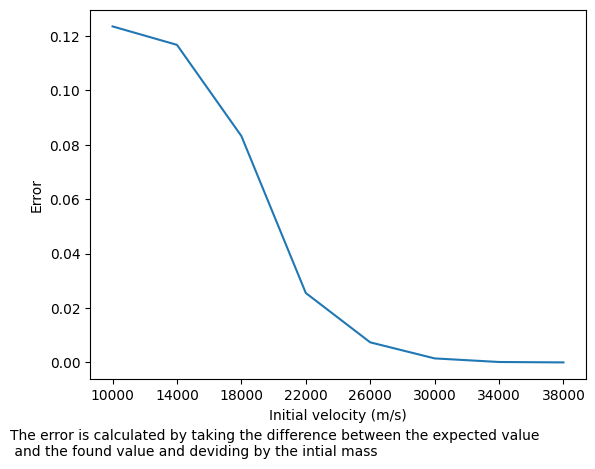

In [6]:
plt.plot(errors)
plt.xticks(ticks = list(range(8)), labels = init_velo)
plt.xlabel('Initial velocity (m/s)')
plt.ylabel('Error')
plt.figtext(0.0, -0.05 , 'The error is calculated by taking the difference between the expected value \n and the found value and deviding by the intial mass')
plt.show()

The experiment

For each of the given velocities and masses from the NASA dataset, the simulation will be run using different angels of impact. 
The results will be saved in a file.

In [7]:
filename = 'nasa_dataset\\impacts.csv'


asteroids = Asteroids(filename)
V_inits = asteroids.velocity()
M_inits = asteroids.mass()

In [8]:
print(V_inits[0])
print(M_inits[0])

17770.0
628580.3301057577


In [9]:
results = defaultdict(dict)
results

defaultdict(dict, {})

In [23]:
results = defaultdict(dict)

# for i in range(2):
#     results[i]['angle of entry'] = np.zeros(7)
#     results[i]['final mass'] = np.zeros(7)
#     results[i]['final velo'] = np.zeros(7)
#     results[i]['final height'] = np.zeros(7)
#     results[i]['hit'] = []
#     results[i]['time elapsed'] = np.zeros(7)

angles : list[float] = [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0]

for angle in angles:
    for i in range(4):
        masses, velocities, heights, hit, t = sim(V_inits[i], M_inits[i], angle)
        results[i][angle] = (masses[int(t/dt)-1], velocities[int(t/dt)-1], heights[int(t/dt)-1], hit, t)
        # results[i]['final mass'][angles.index(angle)] = masses[int(t/dt)-1]
        # results[i]['final velo'][angles.index(angle)] = velocities[int(t/dt)-1]
        # results[i]['final height'][angles.index(angle)] = heights[int(t/dt)-1]
        # results[i]['hit'].append(hit)
        # results[i]['time elapsed'][angles.index(angle)] = t
    

In [24]:
print(results)

defaultdict(<class 'dict'>, {0: {0.0: (16772.755023759997, 5455.549197963018, -4.530311702425306, True, 11.67199999999897), 15.0: (17681.419650535303, 5193.529241515708, -4.018894553948921, True, 12.17699999999869), 30.0: (14864.528505738546, 4109.089626191874, -2.516301595036916, True, 13.686999999997854), 45.0: (12604.693749131087, 2432.5766415573635, -0.8134628651627991, True, 17.262999999998115), 60.0: (13431.775997310597, 784.7052258127036, -0.31882941185348246, True, 27.74000000001092), 75.0: (10196.741099288356, 176.2653067019609, -0.009637278000131068, True, 122.1510000002192), 90.0: (628580.3283612599, 13813.95364067415, 200000.0, False, 900.0009999856297)}, 1: {0.0: (5129.824715650431, 732.0981915144818, -0.47822437255908545, True, 26.04600000000885), 15.0: (5590.427149336266, 638.0718241522789, -0.1786291062231501, True, 27.917000000011136), 30.0: (5319.9924850387915, 475.84553059047056, -0.25370131251178485, True, 32.23700000001557), 45.0: (5164.230758746707, 260.9262382583

The result dictionary looks like this:

{number of asteroid: {angle : (final mass, final velocity, final height, hit or not, duration of sim), angle : ..etc}}

Plot of the angle's effect on the change in velocity

the change in velocity will be:
(init_velo - final_velo) / init velo

In [43]:
angles_plt : list[float] = []
velo_change: list[float] = []

for angle in angles:
    for asteroid in results:
        start_velo = V_inits[asteroid]
        end_velo = results[asteroid][angle][1]
        velo_change.append((start_velo - end_velo) / start_velo)
        angles_plt.append(angle)

print(velo_change)
print(angles_plt)

[0.6929910411951031, 0.9184745889182091, 0.9946632933483106, 0.15939142971339246, 0.7077361147149291, 0.9289452311634433, 1.000000290749202, 0.2761169190088684, 0.7687625421388928, 0.9470105199787895, 0.9979122040532983, 0.2384750636184684, 0.8631076735195631, 0.9709436260291354, 0.9962342203875323, 0.2567089477737842, 0.9558410114905626, 1.0000008460221825, 1.0000001154954195, 0.49616184644559014, 0.9900807368203737, 0.9830558126768685, 0.9952030250342577, 0.5408194236607123, 0.22262500615227068, 0.4405396834528544, 0.2158235885737991, 0.7927948602397191]
[0.0, 0.0, 0.0, 0.0, 15.0, 15.0, 15.0, 15.0, 30.0, 30.0, 30.0, 30.0, 45.0, 45.0, 45.0, 45.0, 60.0, 60.0, 60.0, 60.0, 75.0, 75.0, 75.0, 75.0, 90.0, 90.0, 90.0, 90.0]


Text(0, 0.5, 'Change in velocity ((initial - final) / initial)')

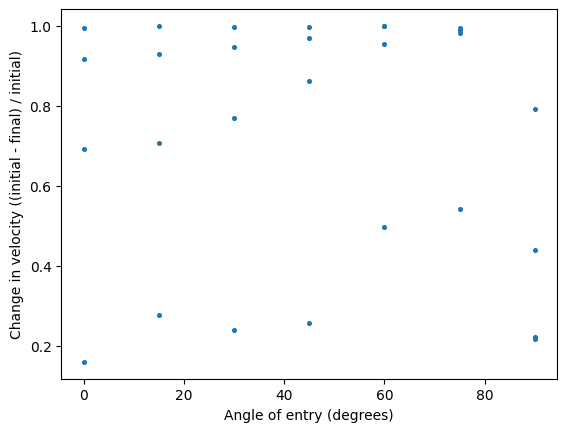

In [44]:
plt.scatter(angles_plt, velo_change, s = 7, )
plt.xlabel('Angle of entry (degrees)')
plt.ylabel('Change in velocity ((initial - final) / initial)')


change in mass depending on angel of entry

In [41]:
angles_plt2 : list[float] = []
mass_change: list[float] = []

for angle in angles:
    for asteroid in results:
        start_mass = M_inits[asteroid]
        end_mass = results[asteroid][angle][0]
        mass_change.append((start_mass - end_mass) / start_mass)
        angles_plt2.append(angle)

Text(0, 0.5, 'Change in mass ((initial - final) / initial)')

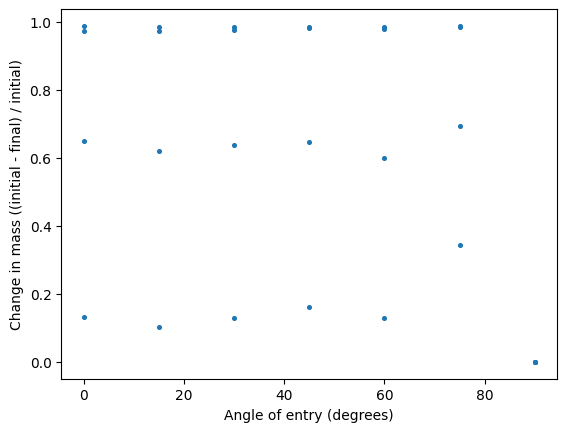

In [42]:
plt.scatter(angles_plt, mass_change, s = 7, )
plt.xlabel('Angle of entry (degrees)')
plt.ylabel('Change in mass ((initial - final) / initial)')

In [45]:
# scatterplot of change in velocity vs change in mass? for one angle

ding = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}

for i in ding:
        masses, velocities, heights, hit, t = sim(V_inits[i], M_inits[i], 45.0)
        ding[i] = [masses[int(t/dt)-1], velocities[int(t/dt)-1], heights[int(t/dt)-1], hit, t]


In [46]:
print(ding)

{0: [12604.693749131087, 2432.5766415573635, -0.8134628651627991, True, 17.262999999998115], 1: [5164.230758746707, 260.9262382583631, -0.007514742125371648, True, 44.6679999999866], 2: [212.0467063036552, 69.02674029653244, -0.04768105780139919, True, 100.26200000011468], 3: [6296831.260682706, 3709.022350608817, -1.737186857158231, True, 55.82799999996059], 4: [202395286374.53607, 19316.75957397585, -8.87378593148998, True, 14.512999999997396], 5: [2329497872.000439, 5915.540658401104, -0.026381811175462566, True, 46.45199999998244]}


In [47]:
velo_change2 : list[float] = []
mass_change2: list[float] = []

for asteroid in ding:
    start_mass = M_inits[asteroid]
    end_mass = ding[asteroid][0]
    start_velo = V_inits[asteroid]
    end_velo = ding[asteroid][1]
    mass_change2.append((start_mass - end_mass) / start_mass)
    velo_change2.append((start_velo - end_velo) / start_velo)
    

Text(0, 0.5, 'Change in mass ((initial - final) / initial)')

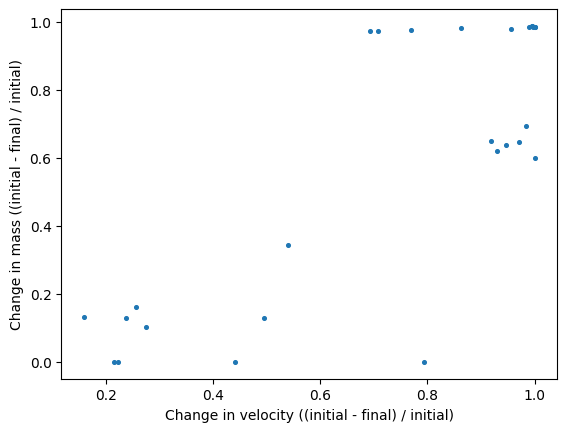

In [48]:
plt.scatter(velo_change, mass_change, s = 7, )
plt.xlabel('Change in velocity ((initial - final) / initial)')
plt.ylabel('Change in mass ((initial - final) / initial)')